In [1]:
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Dataset Type
n = 9

In [3]:
# Import Data and convert to tensor
binary = True

X = np.load("Datasets/kryptonite-%s-X.npy" % (n))
y = np.load("Datasets/kryptonite-%s-y.npy" % (n))
if binary:
    X = np.where(X > 0.5, 1, 0)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)  # 20% test

X_temp = torch.tensor(X_temp.astype(np.float32)).to(device)
y_temp = torch.tensor(y_temp.astype(np.float32)).unsqueeze(1).to(device)

X_test = torch.tensor(X_test.astype(np.float32)).to(device)
y_test = torch.tensor(y_test.astype(np.float32)).unsqueeze(1).to(device)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, shuffle=False)

In [4]:
# Define Model


class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_layer_size, num_hidden_layers):
        super(NeuralNet, self).__init__()
        layers = [
            nn.Linear(input_dim, hidden_layer_size),
            nn.ReLU(),
        ]
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_layer_size, hidden_layer_size))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_layer_size, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [5]:
plots_dir = Path("Plots/HyperparameterTuning")
results_dir = Path("Results/HyperparameterTuning")

In [6]:
def plot_accuracy(train_acc_list, val_acc_list, id=None):
    # Mean and std across each each kth fold of validation
    train_acc = []
    val_acc = []

    for i in range(5):
        train_acc.append(train_acc_list[i])
        val_acc.append(val_acc_list[i])

    train_acc = np.array(train_acc)
    val_acc = np.array(val_acc)

    train_mean = np.mean(train_acc, axis=0)
    val_mean = np.mean(val_acc, axis=0)

    train_std = np.std(train_acc, axis=0)
    val_std = np.std(val_acc, axis=0)

    plt.plot(train_mean)
    plt.fill_between(
        range(len(train_mean)),
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.6,
    )
    plt.title("Training Accuracy per epoch")
    if id:
        plt.savefig(f"{dir}/train_acc_{id}.png")
    else:
        plt.savefig(f"{dir}/train_acc.png")
    plt.close()

    plt.plot(val_mean)
    plt.fill_between(
        range(len(val_mean)), val_mean - val_std, val_mean + val_std, alpha=0.6
    )
    plt.title("Validation Accuracy per epoch")
    if id:
        plt.savefig(f"{dir}/val_acc_{id}.png")
    else:
        plt.savefig(f"{dir}/val_acc.png")
    plt.close()

    print("Training accuracy (last epoch)")
    for i in range(5):
        print("K-fold", i, ":", train_acc[i][-1])
    print("---------------------------------")
    print("Validation accuracy (last epoch)")
    for i in range(5):
        print("K-fold", i, ":", val_acc[i][-1])
    print("---------------------------------")

    print("Training accuracy (best)")
    for i in range(5):
        print("K-fold", i, ":", train_acc[i].max())
    print("---------------------------------")

    average_best_validation_accuracy = 0
    print("Validation accuracy (best)")
    for i in range(5):
        print("K-fold", i, ":", val_acc[i].max())
        average_best_validation_accuracy += val_acc[i].max()
    print("---------------------------------")
    average_best_validation_accuracy /= 5

    print(f"Average best validation accuracy: {average_best_validation_accuracy}")
    print("---------------------------------")

    return average_best_validation_accuracy

In [7]:
def plot_losses(train_loss_list, val_loss_list, id=None):
    # Mean and std across each each kth fold of validation
    train_loss = []
    val_loss = []

    for i in range(5):
        train_loss.append(train_loss_list[i])
        val_loss.append(val_loss_list[i])

    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)

    train_mean = np.mean(train_loss, axis=0)
    val_mean = np.mean(val_loss, axis=0)

    train_std = np.std(train_loss, axis=0)
    val_std = np.std(val_loss, axis=0)

    plt.plot(train_mean)
    plt.fill_between(
        range(len(train_mean)),
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.6,
    )
    plt.title("Training Loss per epoch")
    if id:
        plt.savefig(f"{dir}/train_loss_{id}.png")
    else:
        plt.savefig(f"{dir}/train_loss.png")
    plt.close()

    plt.plot(val_mean)
    plt.fill_between(
        range(len(val_mean)), val_mean - val_std, val_mean + val_std, alpha=0.6
    )
    plt.title("Validation Loss per epoch")
    if id:
        plt.savefig(f"{dir}/val_loss_{id}.png")
    else:
        plt.savefig(f"{dir}/val_loss.png")
    plt.close()

    print("Training loss (last epoch)")
    for i in range(5):
        print("K-fold", i, ":", train_loss[i][-1])
    print("---------------------------------")
    print("Validation loss (last epoch)")
    for i in range(5):
        print("K-fold", i, ":", val_loss[i][-1])
    print("---------------------------------")

    print("Training loss best")
    for i in range(5):
        print("K-fold", i, ":", train_loss[i].min())
    print("---------------------------------")

    avg_best_validation_loss = 0
    print("Validation loss (best)")
    for i in range(5):
        print("K-fold", i, ":", val_loss[i].min())
        avg_best_validation_loss += val_loss[i].min()
    print("---------------------------------")
    avg_best_validation_loss /= 5

    print(f"Average best validation loss: {avg_best_validation_loss}")
    print("---------------------------------")

    return avg_best_validation_loss

In [8]:
def model_training(hyperparameters):
    # Store loss and accuracy for each K-fold
    train_acc_list = {0: [], 1: [], 2: [], 3: [], 4: []}
    val_acc_list = {0: [], 1: [], 2: [], 3: [], 4: []}

    train_loss_list = {0: [], 1: [], 2: [], 3: [], 4: []}
    val_loss_list = {0: [], 1: [], 2: [], 3: [], 4: []}

    # Enable or disable early stopping
    early_stopping_enabled = False

    # K-fold training loop
    count = 0
    kf = KFold(n_splits=5, shuffle=True)
    for train_index, val_index in kf.split(X_temp):
        X_train_tensor, X_val_tensor = X_temp[train_index], X_temp[val_index]
        y_train_tensor, y_val_tensor = y_temp[train_index], y_temp[val_index]

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, batch_size=hyperparameters["batch_size"], shuffle=True
        )

        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_loader = DataLoader(val_dataset, batch_size=hyperparameters["batch_size"])

        model = NeuralNet(
            n, hyperparameters["hidden_size"], hyperparameters["num_hidden"]
        ).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(
            model.parameters(),
            lr=hyperparameters["lr"],
            weight_decay=hyperparameters["alpha"],
        )

        num_epochs = hyperparameters["num_epochs"]

        # Variables required for early stopping
        early_stopping_counter = 0
        patience = 5
        best_val_loss = float("inf")

        for _ in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0  # accuracy cal
            for input, label in train_loader:
                optimizer.zero_grad()
                outputs = model(input)
                loss = criterion(outputs, label)
                loss.backward()
                optimizer.step()

                correct += (outputs.round() == label).float().sum().item()
                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            accuracy = 100 * correct / len(X_train_tensor)
            train_loss_list[count].append(avg_loss)
            train_acc_list[count].append(accuracy)

            model.eval()
            valid_loss = 0.0
            correct = 0
            for input, label in val_loader:
                target = model(input)
                loss = criterion(target, label)
                valid_loss += loss.item()
                correct += (target.round() == label).float().sum().item()
            avg_loss = valid_loss / len(val_loader)
            accuracy = 100 * correct / len(X_val_tensor)
            val_loss_list[count].append(avg_loss)
            val_acc_list[count].append(accuracy)

            # Early stopping check
            if early_stopping_enabled:
                if avg_loss < best_val_loss:
                    best_val_loss = avg_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                if early_stopping_counter > patience:
                    break

        count += 1

    file_id_for_plot = f"n_{n}"
    for key, val in hyperparameters.items():
        file_id_for_plot += f"_{key}_{val}"
    file_id_for_plot = file_id_for_plot.replace(".", "-")

    print("---------------------------------")
    print(file_id_for_plot)
    print("---------------------------------")

    average_best_validation_accuracy = plot_accuracy(
        train_acc_list, val_acc_list, id=file_id_for_plot
    )
    avg_best_validation_loss = plot_losses(
        train_loss_list, val_loss_list, id=file_id_for_plot
    )

    return average_best_validation_accuracy, avg_best_validation_loss

In [9]:
# Hyperparameter combinations
lr_values = [0.001, 0.01, 0.05, 0.1]
alpha_values = [0.0001, 0.001, 0.01, 0.1]
hidden_layer_sizes = [2 * n, 4 * n, 8 * n, 16 * n]
num_hidden_layers = [1, 2]

In [10]:
# File path to store results
csv_file_path = results_dir / f"hyperparameter_tuning_results-{n}.csv"

In [11]:
# Function to check if the hyperparameter combination already exists in CSV
def is_hyperparameter_row_present(hyperparameters, existing_rows):
    hyperparameter_tuple = tuple(
        sorted({key: str(val) for key, val in hyperparameters.items()}.items())
    )
    return hyperparameter_tuple in existing_rows


# Initialize an empty set to store processed hyperparameter combinations
existing_rows = set()

# Check if the CSV file already exists and load existing rows
if os.path.exists(csv_file_path):
    with open(csv_file_path, mode="r", newline="") as f:
        reader = csv.reader(f)
        # Read the headers and rows from the existing file
        headers = next(reader)
        for row in reader:
            # Convert each row back into a dictionary of hyperparameters
            row_dict = dict(zip(headers, row))
            row_dict.pop("val_acc")
            row_dict.pop("val_loss")
            # Create a hashable tuple for checking if the row already exists
            existing_rows.add(tuple(sorted(row_dict.items())))

# Iterate through hyperparameter combinations
for lr in lr_values:
    for alpha in alpha_values:
        for hidden_layer_size in hidden_layer_sizes:
            for num_hidden in num_hidden_layers:
                hyperparameters = {
                    "num_hidden": num_hidden,
                    "hidden_size": hidden_layer_size,
                    "lr": lr,
                    "alpha": alpha,
                    "batch_size": 128,
                    "num_epochs": 100,
                }

                # Check if this combination has already been processed
                if is_hyperparameter_row_present(hyperparameters, existing_rows):
                    print(
                        f"Skipping already processed hyperparameter combination: {hyperparameters}"
                    )
                    continue  # Skip to the next combination

                # Compute the result (training the model)
                val_acc, val_loss = model_training(hyperparameters)

                # Prepare the result row
                result_row = {
                    **hyperparameters,
                    "val_acc": val_acc,
                    "val_loss": val_loss,
                }

                # Append the result to the CSV file
                with open(csv_file_path, mode="a", newline="") as f:
                    writer = csv.DictWriter(f, fieldnames=result_row.keys())

                    # Write header only if the file is empty (first write)
                    if f.tell() == 0:
                        writer.writeheader()

                    writer.writerow(result_row)

                # Add this combination to the existing_rows set to avoid recalculation in future runs
                existing_rows.add(tuple(sorted(hyperparameters.items())))

Skipping already processed hyperparameter combination: {'num_hidden': 1, 'hidden_size': 18, 'lr': 0.001, 'alpha': 0.0001, 'batch_size': 128, 'num_epochs': 100}
Skipping already processed hyperparameter combination: {'num_hidden': 2, 'hidden_size': 18, 'lr': 0.001, 'alpha': 0.0001, 'batch_size': 128, 'num_epochs': 100}
Skipping already processed hyperparameter combination: {'num_hidden': 1, 'hidden_size': 36, 'lr': 0.001, 'alpha': 0.0001, 'batch_size': 128, 'num_epochs': 100}
Skipping already processed hyperparameter combination: {'num_hidden': 2, 'hidden_size': 36, 'lr': 0.001, 'alpha': 0.0001, 'batch_size': 128, 'num_epochs': 100}
Skipping already processed hyperparameter combination: {'num_hidden': 1, 'hidden_size': 72, 'lr': 0.001, 'alpha': 0.0001, 'batch_size': 128, 'num_epochs': 100}
Skipping already processed hyperparameter combination: {'num_hidden': 2, 'hidden_size': 72, 'lr': 0.001, 'alpha': 0.0001, 'batch_size': 128, 'num_epochs': 100}
Skipping already processed hyperparamete

In [12]:
accuracy_thresholds = {
    9: 0.95,
    12: 0.925,
    15: 0.9,
}


def plot_val_accuracy_vs(n, hyperparameter, desc, ax):
    """
    Plot validation accuracy vs a given hyperparameter, with points equidistant on the x-axis.
    Add validation accuracy values on top of each point using annotations and manage layout.

    Parameters:
        n (int): Used for naming and computations.
        hyperparameter (str): The hyperparameter to plot against.
        desc (str): Description or label for the hyperparameter axis.
    """

    csv_file_path = results_dir / f"hyperparameter_tuning_results-{n}.csv"
    selected_hyperparameters = {
        "num_hidden": 1,
        "hidden_size": 4 * n,
        "lr": 0.01,
        "alpha": 0.0001,
        "batch_size": 128,
        "num_epochs": 100,
    }
    data = pd.read_csv(csv_file_path)
    data["val_acc"] /= 100  # Optional normalization for val_acc (remove if not needed)

    # Dynamically build the filter condition
    filter_condition = pd.Series([True] * len(data))
    for key, value in selected_hyperparameters.items():
        if key != hyperparameter:
            filter_condition &= data[key] == value
    filtered_data = data[filter_condition]

    # Plot using equidistant points
    x_positions = range(len(filtered_data))  # Equidistant points
    ax.plot(
        x_positions,
        filtered_data["val_acc"],
        marker="o",
        linestyle="-",
        label="Validation accuracy",
        color="b",
    )

    # Replace x-axis ticks with hyperparameter values
    if hyperparameter == "hidden_size":
        ticks = [f"{int(tick/n)}n" for tick in filtered_data[hyperparameter]]
    else:
        ticks = filtered_data[hyperparameter]
    ax.set_xticks(x_positions, ticks, rotation=45)

    # Add red dashed line for accuracy threshold
    if n in accuracy_thresholds:
        threshold = accuracy_thresholds[n]
        ax.axhline(
            y=threshold, color="red", linestyle="--", label=f"Acuuracy threshold"
        )  # {threshold:.2f}')

    # Add labels and title
    if n == 15:
        ax.set_xlabel(desc)
    if hyperparameter == "lr":
        ax.set_ylabel("Validation Accuracy")

    if n == 9 and hyperparameter == "hidden_size":
        ax.legend(loc="best")

    ax.set_title(f"n = {n} ({desc})")
    ax.grid(True)
    ax.set_ylim(top=1, bottom=0.5)

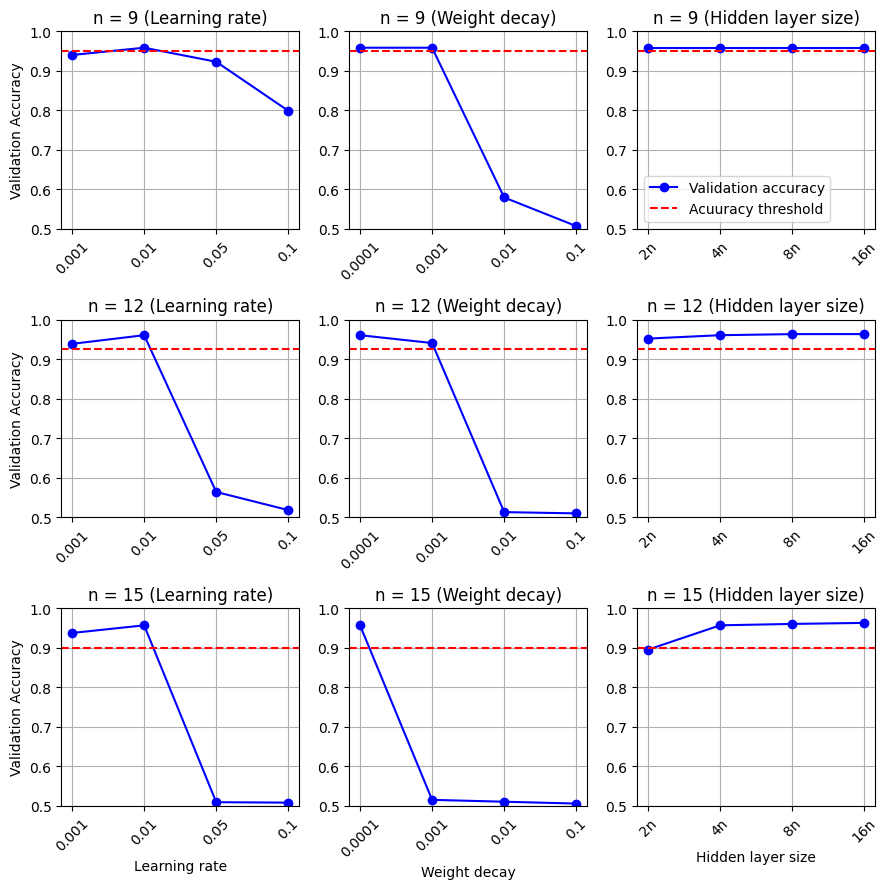

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, n in enumerate([9, 12, 15]):
    plot_val_accuracy_vs(n, "lr", "Learning rate", axes[i, 0])
    plot_val_accuracy_vs(n, "alpha", "Weight decay", axes[i, 1])
    plot_val_accuracy_vs(n, "hidden_size", "Hidden layer size", axes[i, 2])

plt.tight_layout()  # Apply tight layout after adjusting

# Save the plot with bbox_inches='tight' to include all elements
plt.savefig(
    plots_dir / f"hyperparameter-tuning-all-n.svg", format="svg", bbox_inches="tight"
)
plt.show()